# Notebook for Part 3

This notebook contains the script and analysis for part 3 of the assessment 3.

In [1]:
import pandas as pd
import numpy as np
import re
import os
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.cluster import KMeans
import statsmodels.api as sm
from math import sin, cos, sqrt, atan2, radians
from sklearn.preprocessing import normalize
from outliers import smirnov_grubbs as grubbs

## Pre-processing Happiness Data

In [2]:
# Create a path to the wellbeing folder in raw_data folder
raw_wellbeing_path = '../raw_data/wellbeing'

# Check the files within
wellbeing_file_lst = os.listdir(raw_wellbeing_path)
wellbeing_file_lst

['20112012referencetabletcm77332122.xls',
 '20122013referencetable_tcm77-332116.xls',
 'geographicbreakdownreferencetable_tcm77-417203.xls',
 'referencetable1geographicalbreakdown_tcm77-378058.xls']

In [3]:
def extract_happiness(file_name):
    '''
    Function to extract the happiness data from a given filename (assumed to be in the raw_wellbeing_path)
    and returns a pandas dataframe object.
    file_name (string): name of the wellbeing file name
    '''
    
    path_name = os.path.join(raw_wellbeing_path,file_name)

    raw_df = pd.read_excel(path_name, 'Happiness', header = None)

    raw_df = raw_df.dropna(how = 'all').reset_index(drop = True)

    # Get the year from the first cell
    year = re.findall('April (\d{4})',raw_df.loc[0,0])[0]

    # For this analysis, I will just use the data all the way up to "Average rating" column for analysis
    last_col = raw_df[raw_df.applymap(lambda x: re.search('Average',str(x)) is not None)].dropna(how = 'all', axis = 1).columns[0]

    # Get the index of the last header row by recognising Codes in the first column
    last_header_index = raw_df.loc[:,0][raw_df.loc[:,0].apply(lambda x: True if re.search('Codes',str(x)) is not None else False)].index[0]

    for j in range(last_col+1):
        raw_df.loc[1:last_header_index, j] = raw_df.loc[1:last_header_index, j].fillna(method = 'ffill')

    # Get the index of the first row of the "appendix", we will determine the row above to be the last row to cut off
    bool_arr = raw_df.loc[:,0].apply(lambda x: re.search('1 Question: Overall, how happy did you feel yesterday\?',str(x)) is not None)
    last_row_index = raw_df[bool_arr].index[0] - 1

    # Get the data out
    interim_df = raw_df.loc[last_header_index:last_row_index,:last_col]
    cols_to_drop = interim_df.loc[last_header_index][interim_df.loc[last_header_index].isnull()].index
    interim_df = interim_df.drop(columns = cols_to_drop)

    # Assign header
    header_lst = interim_df.loc[last_header_index].tolist()
    interim_df.columns = [header.strip() for header in header_lst]
    interim_df = interim_df.drop(last_header_index)

    # Drop those entries where area names is nan
    interim_df = interim_df.dropna(subset=['Area names'])

    # Reset index
    interim_df = interim_df.reset_index(drop = True)
    
    # Add year
    interim_df['year'] = year
    
    # Rename columns
    interim_df = interim_df.rename(columns = {'Codes': 'Area Codes', 'Average (mean) rating': 'Average rating'})
    
    return interim_df

In [4]:
happiness_df = pd.concat([extract_happiness(wellbeing_file) for wellbeing_file in wellbeing_file_lst])
happiness_df

,Area Codes,Area names,0-4,5-6,7-8,9-10,Average rating,year
0,K02000001,UNITED KINGDOM,10.88,18.04,39.32,31.76,7.28,2011
1,E92000001,ENGLAND,10.84,18.18,39.37,31.6,7.28,2011
2,E12000001,NORTH EAST,12.16,18.78,38.59,30.47,7.18,2011
3,E12000002,NORTH WEST,11.44,18.97,38.44,31.15,7.23,2011
4,E12000003,YORKSHIRE AND THE HUMBER,11.79,17.88,38.52,31.8,7.24,2011
5,E12000004,EAST MIDLANDS,10.93,17.66,38.35,33.07,7.32,2011
6,E12000005,WEST MIDLANDS,11.5,19.69,37.66,31.16,7.2,2011
7,E12000006,EAST,9.66,17.02,40.96,32.36,7.37,2011
8,E12000007,LONDON,11.17,19.48,40.16,29.2,7.19,2011
9,E12000008,SOUTH EAST,9.87,17.34,40.57,32.21,7.35,2011


Join with regions.txt

In [5]:
# Load regions.txt
regions_df = pd.read_csv('../supp_data/regions.txt', header = None)
regions_df

,0,1,2,3
0,E12000001,NORTH EAST,55.0,-1.9
1,E12000002,NORTH WEST,54.0,-2.6
2,E12000003,YORKSHIRE AND THE HUMBER,53.6,-1.2
3,E12000004,EAST MIDLANDS,53.0,-0.8
4,E12000005,WEST MIDLANDS,52.5,-2.3
5,E12000006,EAST,52.2,0.4
6,E12000007,LONDON,51.5,-0.1
7,E12000008,SOUTH EAST,51.3,-0.5
8,E12000009,SOUTH WEST,51.0,-3.2
9,W92000004,WALES,51.5,-3.2


In [6]:
# Provide corresponding headers for regions_df
regions_df.columns = ['Area Codes','Area names','lat','lon']
regions_df

,Area Codes,Area names,lat,lon
0,E12000001,NORTH EAST,55.0,-1.9
1,E12000002,NORTH WEST,54.0,-2.6
2,E12000003,YORKSHIRE AND THE HUMBER,53.6,-1.2
3,E12000004,EAST MIDLANDS,53.0,-0.8
4,E12000005,WEST MIDLANDS,52.5,-2.3
5,E12000006,EAST,52.2,0.4
6,E12000007,LONDON,51.5,-0.1
7,E12000008,SOUTH EAST,51.3,-0.5
8,E12000009,SOUTH WEST,51.0,-3.2
9,W92000004,WALES,51.5,-3.2


In [7]:
# Inner Join happiness_df to regions_df
print('Number of records before join:', len(happiness_df))
happiness_df = happiness_df.merge(regions_df, how = 'inner',on = ['Area Codes','Area names'])

Number of records before join: 56


In [8]:
print('Number of records after join:', len(happiness_df))

Number of records after join: 43


In [9]:
happiness_df

,Area Codes,Area names,0-4,5-6,7-8,9-10,Average rating,year,lat,lon
0,E12000001,NORTH EAST,12.16,18.78,38.59,30.47,7.18,2011,55.0,-1.9
1,E12000001,NORTH EAST,12.55,18.19,38.58,30.69,7.17,2012,55.0,-1.9
2,E12000001,NORTH EAST,10.77,17.05,39.06,33.13,7.34,2014,55.0,-1.9
3,E12000001,NORTH EAST,11.58,17.48,38.59,32.35,7.29,2013,55.0,-1.9
4,E12000003,YORKSHIRE AND THE HUMBER,11.79,17.88,38.52,31.8,7.24,2011,53.6,-1.2
5,E12000003,YORKSHIRE AND THE HUMBER,10.87,19.01,38.41,31.7,7.27,2012,53.6,-1.2
6,E12000003,YORKSHIRE AND THE HUMBER,10.21,16.6,38.56,34.63,7.41,2014,53.6,-1.2
7,E12000003,YORKSHIRE AND THE HUMBER,10.79,16.96,38.53,33.72,7.34,2013,53.6,-1.2
8,E12000004,EAST MIDLANDS,10.93,17.66,38.35,33.07,7.32,2011,53.0,-0.8
9,E12000004,EAST MIDLANDS,10.07,17.81,39.78,32.34,7.35,2012,53.0,-0.8


In [10]:
# Export
happiness_df.to_excel('../proc_data/happiness/happiness.xlsx', index = None)

Assume that to a first approximation the general climate at a given weather stations is fairly constant over time and that happiness also does not change too much from year to year.

In [11]:
happiness_df[['0-4', '5-6', '7-8', '9-10','Average rating','lat', 'lon']] = happiness_df[['0-4', '5-6', '7-8', '9-10','Average rating','lat', 'lon']].astype(float)

In [12]:
happiness_df_avg = happiness_df.groupby(['Area Codes','Area names'])[['0-4', '5-6', '7-8', '9-10','Average rating','lat', 'lon']].mean()
happiness_df_avg = happiness_df_avg.reset_index()

In [13]:
happiness_df_avg

,Area Codes,Area names,0-4,5-6,7-8,9-10,Average rating,lat,lon
0,E12000001,NORTH EAST,11.765000,17.875000,38.705000,31.660000,7.2450,55.0,-1.9
1,E12000003,YORKSHIRE AND THE HUMBER,10.915000,17.612500,38.505000,32.962500,7.3150,53.6,-1.2
2,E12000004,EAST MIDLANDS,9.737500,17.560000,38.975000,33.732500,7.3975,53.0,-0.8
3,E12000005,WEST MIDLANDS,10.052500,18.265000,40.285000,31.405000,7.3200,52.5,-2.3
4,E12000006,EAST,9.155000,16.842500,41.325000,32.677500,7.4125,52.2,0.4
5,E12000007,LONDON,9.842500,18.772500,41.665000,29.722500,7.2750,51.5,-0.1
6,E12000008,SOUTH EAST,8.922500,16.957500,41.300000,32.817500,7.4225,51.3,-0.5
7,E12000009,SOUTH WEST,9.717500,16.642500,40.295000,33.347500,7.4075,51.0,-3.2
8,N92000002,NORTHERN IRELAND,8.703333,14.313333,41.106667,35.913333,7.5500,54.6,-5.9
9,S92000003,SCOTLAND,10.132500,17.017500,40.382500,32.470000,7.3575,56.0,-3.2


In [14]:
# Load the weather data
proc_weather_path = '..\proc_data\weather'
weather_df = pd.read_csv(os.path.join(proc_weather_path,'weather.csv'))

In [15]:
weather_df_agg = weather_df.groupby('station')[['tmax degC','tmin degC','af days','rain mm','sun hours','lat','lon']].mean().reset_index()

In [16]:
weather_df_agg

,station,tmax degC,tmin degC,af days,rain mm,sun hours,lat,lon
0,aberporth,12.446138,7.218297,1.535668,76.347975,129.096523,52.139,-4.570
1,armagh,12.946581,5.665598,3.299679,68.810406,103.913016,54.352,-6.649
2,ballypatrick,11.374561,5.534897,2.640063,110.254522,106.663636,55.181,-6.153
3,bradford,12.294444,5.720074,3.753333,72.914059,104.131172,53.813,-1.772
4,braemar,10.515747,2.749529,8.687752,75.632083,98.446739,57.006,-3.396
5,camborne,13.434834,8.375342,0.759295,90.132877,134.300198,50.218,-5.327
6,cambridge,14.285007,6.200268,3.597055,46.328907,125.000000,52.245,0.102
7,cardiff,14.639962,7.043212,2.969407,97.630975,123.556054,51.488,-3.187
8,chivenor,14.527559,7.871287,1.728606,75.225569,138.594142,51.089,-4.147
9,cwmystwyth,11.642314,4.886000,5.113523,149.432712,97.186254,52.358,-3.802


In [17]:
def compute_distance(lat1, lon1, lat2, lon2):
    '''
    Function to compute distance between to points given their lat long.
    Adapted from source: "https://stackoverflow.com/questions/19412462/getting-distance-between-two-points-based-on-latitude-longitude"
    lat1 (float): latitude of point 1
    lon1 (float): longitude of point 1
    lat2 (float): latitude of point 2
    lon2 (float): longitude of point 2
    '''
    # approximate radius of earth in km
    R = 6373.0

    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c
    return distance

In [18]:
def assign_nearest_region_merge(weather_df_agg, happiness_df_avg):
    '''
    Assign the nearest region to the station based on the lat long and merge to weather df
    weather_df_agg (dataframe): aggregated weather data
    happiness_df_ave (dataframe): average happiness data
    '''
    
    for i in range(len(weather_df_agg)):
        # For each station find the the nearest region and assign region to it

        dist_lst = []

        for j in range(len(happiness_df_avg)):
            dist_lst.append(compute_distance(happiness_df_avg.loc[j,'lat'], happiness_df_avg.loc[j,'lon'], weather_df_agg.loc[i, 'lat'], weather_df_agg.loc[i, 'lon']))

            # Find the shortest distances
            weather_df_agg.loc[i,'Region'] = happiness_df_avg.loc[np.argmin(dist_lst),'Area names']

            # Keep region lat lon for manual sanity checks
            weather_df_agg.loc[i,'Region lat'] = happiness_df_avg.loc[np.argmin(dist_lst),'lat']
            weather_df_agg.loc[i,'Region lon'] = happiness_df_avg.loc[np.argmin(dist_lst),'lon']

    # Merge with the happiness_df_avg
    weather_df_agg = pd.merge(weather_df_agg, happiness_df_avg.drop(columns = ['Area Codes','lat','lon']), how = 'left', left_on = 'Region', right_on = 'Area names')
    weather_df_agg = weather_df_agg.drop(columns = 'Area names')
    
    return weather_df_agg

In [19]:
weather_df_agg = assign_nearest_region_merge(weather_df_agg, happiness_df_avg)

In [30]:
weather_df_agg

,station,tmax degC,tmin degC,af days,rain mm,sun hours,lat,lon,Region,Region lat,Region lon,0-4,5-6,7-8,9-10,Average rating
0,aberporth,12.446138,7.218297,1.535668,76.347975,129.096523,52.139,-4.570,WALES,51.5,-3.2,10.575000,17.132500,39.137500,33.155000,7.3525
1,armagh,12.946581,5.665598,3.299679,68.810406,103.913016,54.352,-6.649,NORTHERN IRELAND,54.6,-5.9,8.703333,14.313333,41.106667,35.913333,7.5500
2,ballypatrick,11.374561,5.534897,2.640063,110.254522,106.663636,55.181,-6.153,NORTHERN IRELAND,54.6,-5.9,8.703333,14.313333,41.106667,35.913333,7.5500
3,bradford,12.294444,5.720074,3.753333,72.914059,104.131172,53.813,-1.772,YORKSHIRE AND THE HUMBER,53.6,-1.2,10.915000,17.612500,38.505000,32.962500,7.3150
4,braemar,10.515747,2.749529,8.687752,75.632083,98.446739,57.006,-3.396,SCOTLAND,56.0,-3.2,10.132500,17.017500,40.382500,32.470000,7.3575
5,camborne,13.434834,8.375342,0.759295,90.132877,134.300198,50.218,-5.327,SOUTH WEST,51.0,-3.2,9.717500,16.642500,40.295000,33.347500,7.4075
6,cambridge,14.285007,6.200268,3.597055,46.328907,125.000000,52.245,0.102,EAST,52.2,0.4,9.155000,16.842500,41.325000,32.677500,7.4125
7,cardiff,14.639962,7.043212,2.969407,97.630975,123.556054,51.488,-3.187,WALES,51.5,-3.2,10.575000,17.132500,39.137500,33.155000,7.3525
8,chivenor,14.527559,7.871287,1.728606,75.225569,138.594142,51.089,-4.147,SOUTH WEST,51.0,-3.2,9.717500,16.642500,40.295000,33.347500,7.4075
9,cwmystwyth,11.642314,4.886000,5.113523,149.432712,97.186254,52.358,-3.802,WEST MIDLANDS,52.5,-2.3,10.052500,18.265000,40.285000,31.405000,7.3200


## Exploratory Data Analysis and Modelling

This analysis looks at the possible relationships between weather and happiness index

In [20]:
weather_var = ['tmax degC','tmin degC','af days','rain mm','sun hours']
rating_var = ['0-4', '5-6', '7-8', '9-10','Average rating']
cols_interest = weather_var+rating_var

In [21]:
weather_summarised = weather_df_agg.groupby('Region')[cols_interest].mean().reset_index()
weather_summarised = weather_summarised.sort_values('Average rating')
weather_summarised = weather_summarised.reset_index(drop = True)
weather_summarised

,Region,tmax degC,tmin degC,af days,rain mm,sun hours,0-4,5-6,7-8,9-10,Average rating
0,NORTH EAST,12.332768,5.275126,4.171408,61.141503,117.380721,11.765000,17.875000,38.705000,31.660000,7.2450
1,LONDON,13.733582,7.191578,2.323162,49.266595,146.290433,9.842500,18.772500,41.665000,29.722500,7.2750
2,YORKSHIRE AND THE HUMBER,12.756635,6.038571,3.391194,69.240718,110.068761,10.915000,17.612500,38.505000,32.962500,7.3150
3,WEST MIDLANDS,12.701412,5.906308,3.899754,92.143337,115.010183,10.052500,18.265000,40.285000,31.405000,7.3200
4,WALES,13.702101,6.830712,2.756612,78.058512,125.556363,10.575000,17.132500,39.137500,33.155000,7.3525
5,SCOTLAND,11.307185,4.875008,4.488262,91.444147,103.276937,10.132500,17.017500,40.382500,32.470000,7.3575
6,EAST MIDLANDS,13.474136,5.921643,3.830265,50.954629,121.090279,9.737500,17.560000,38.975000,33.732500,7.3975
7,SOUTH WEST,14.270678,7.067075,2.952377,74.011544,135.219935,9.717500,16.642500,40.295000,33.347500,7.4075
8,EAST,13.675444,6.501514,3.089690,48.306822,130.558900,9.155000,16.842500,41.325000,32.677500,7.4125
9,SOUTH EAST,14.296093,7.102976,2.824747,59.616960,137.410657,8.922500,16.957500,41.300000,32.817500,7.4225


In [22]:
# Create a new variable called tvar which means temperature variation between the tmax and tmin
weather_summarised['tvar'] = weather_summarised['tmax degC'] - weather_summarised['tmin degC']

In [23]:
weather_var = ['tmax degC','tmin degC','af days','rain mm','sun hours','tvar']
avg_happiness_rating = ['Average rating']
cols_interest = weather_var + avg_happiness_rating

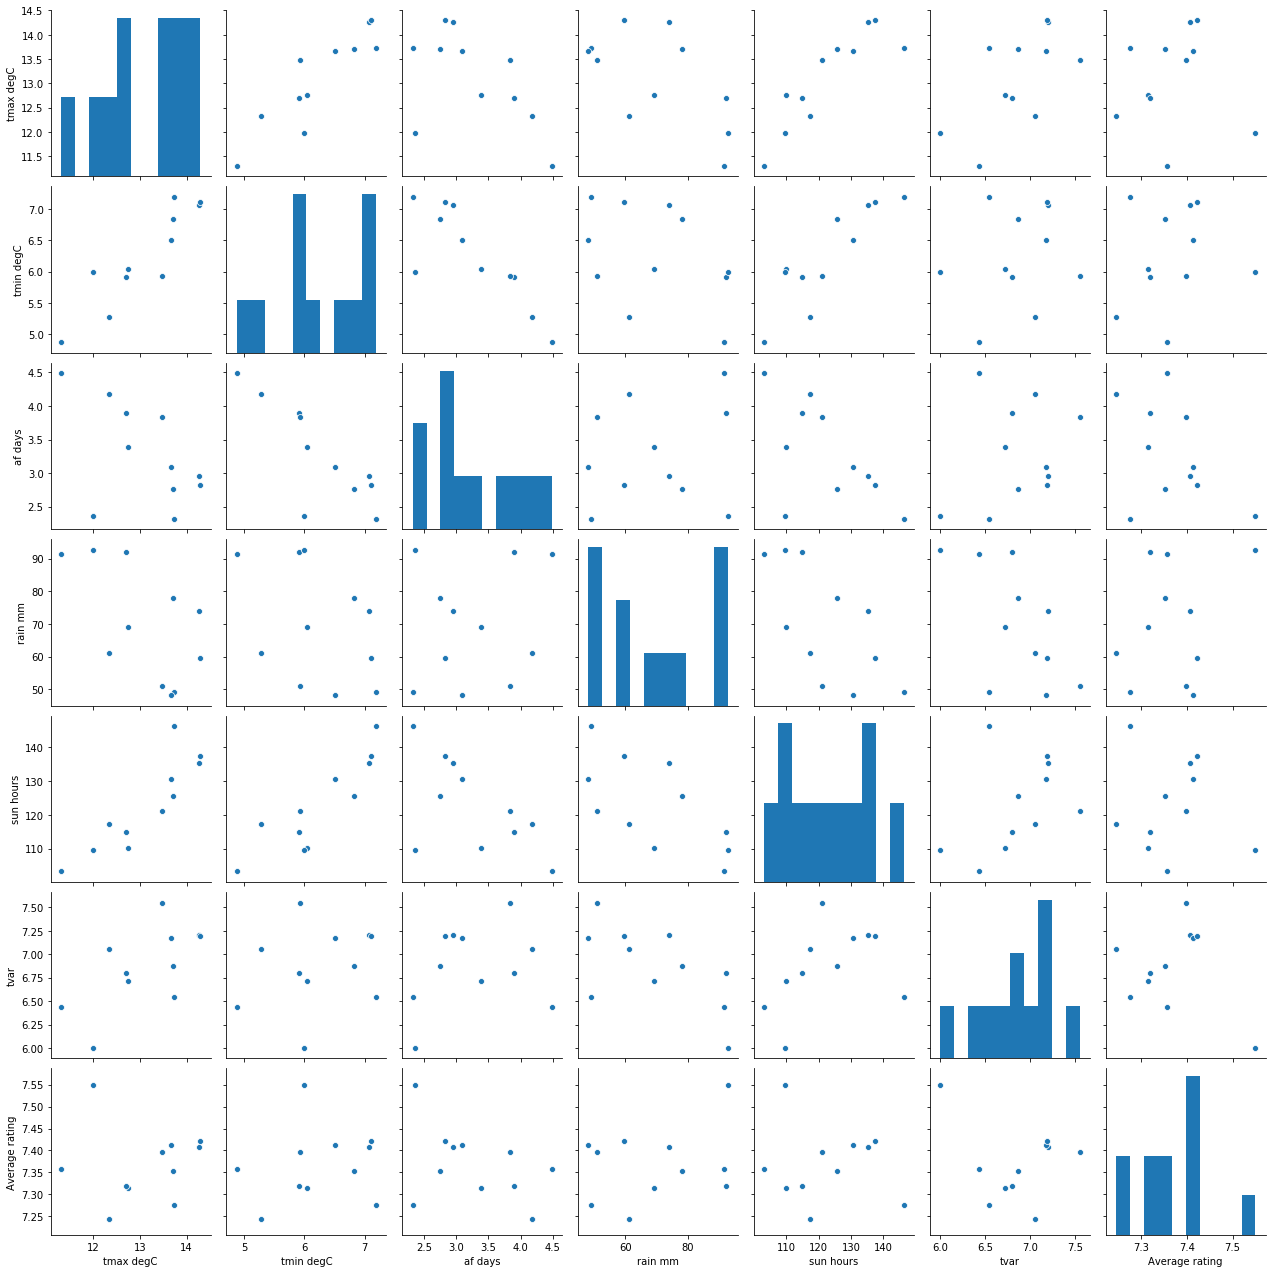

In [24]:
sns.pairplot(weather_summarised[cols_interest])

It does seem like higher max-temperature tends to be associated with higher average happiness index. Furthermore, a temperature variation seems to have a positive association with average happiness index. It does appear that the data point from Northern Ireland seems like a likely candidate for outlier which should be checked.

In [26]:
# Check the correlations of the weather variables with average happiness rating
weather_summarised.corr()

,tmax degC,tmin degC,af days,rain mm,sun hours,0-4,5-6,7-8,9-10,Average rating,tvar
tmax degC,1.000000,0.899637,-0.546968,-0.603790,0.877012,-0.281456,0.215641,0.204315,-0.152921,0.034473,0.639551
tmin degC,0.899637,1.000000,-0.824533,-0.406800,0.874630,-0.418091,0.053413,0.427035,-0.116977,0.152970,0.239699
af days,-0.546968,-0.824533,1.000000,0.184953,-0.607135,0.536619,0.337068,-0.517669,-0.179010,-0.423255,0.235519
rain mm,-0.603790,-0.406800,0.184953,1.000000,-0.661976,-0.004386,-0.423481,-0.051459,0.360192,0.266494,-0.626289
sun hours,0.877012,0.874630,-0.607135,-0.661976,1.000000,-0.286976,0.308248,0.473656,-0.418823,-0.101754,0.410120
0-4,-0.281456,-0.418091,0.536619,-0.004386,-0.286976,1.000000,0.551208,-0.781807,-0.411847,-0.822295,0.110288
5-6,0.215641,0.053413,0.337068,-0.423481,0.308248,0.551208,1.000000,-0.231956,-0.898097,-0.900686,0.385431
7-8,0.204315,0.427035,-0.517669,-0.051459,0.473656,-0.781807,-0.231956,1.000000,-0.116587,0.407327,-0.297556
9-10,-0.152921,-0.116977,-0.179010,0.360192,-0.418823,-0.411847,-0.898097,-0.116587,1.000000,0.850043,-0.134063
Average rating,0.034473,0.152970,-0.423255,0.266494,-0.101754,-0.822295,-0.900686,0.407327,0.850043,1.000000,-0.192671


In [29]:
# Get the correlation of the weather variables with average rating
corr_df = weather_summarised.corr().loc['Average rating'][weather_var].reset_index()
corr_df.columns = ['Weather Variables', 'Correlation']
corr_df

,Weather Variables,Correlation
0,tmax degC,0.034473
1,tmin degC,0.152970
2,af days,-0.423255
3,rain mm,0.266494
4,sun hours,-0.101754
5,tvar,-0.192671


In [25]:
# Conduct the one-sided grubbs test to check for outliers for y at alpha = 0.05
# I did it for both sides
start_records = len(weather_summarised)
weather_summarised = weather_summarised[weather_summarised['Average rating'].isin(grubbs.min_test(weather_summarised['Average rating'], alpha=.05))]
weather_summarised = weather_summarised[weather_summarised['Average rating'].isin(grubbs.max_test(weather_summarised['Average rating'], alpha=.05))]
end_records = len(weather_summarised)
print('{} outliers dropped, {} records remaining'.format(abs(end_records-start_records), end_records))

0 outliers dropped, 11 records remaining


C:\Users\angsi\anaconda3\envs\py36\lib\site-packages\outliers\smirnov_grubbs.py:180: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return data.argmin()
C:\Users\angsi\anaconda3\envs\py36\lib\site-packages\outliers\smirnov_grubbs.py:185: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return data.argmax()


In [26]:
# Do a Multiple Linear Regression of Average Rating against the others for analysis
weather_summarised_subset = weather_summarised[cols_interest]
weather_summarised_subset = weather_summarised_subset.drop(columns = 'tvar') # Drop to prevent collinearity

X = weather_summarised_subset.drop(columns = 'Average rating')
y = weather_summarised_subset['Average rating']

# Outlier test by seeing if any points fall beyond 1.5 IQR from Q1 and Q3 respectively
quartile1 = X.quantile(0.25)
quartile3 = X.quantile(0.75)
IQR = quartile3 - quartile1
condition_check = (X < (quartile1 - 1.5 * IQR)) |(X > (quartile3 + 1.5 * IQR))
if condition_check.sum().sum() > 0:
    tmp = X[condition_check]
    outlier_index = tmp.dropna().index
    X = X.drop(outlier_index)
    print('{} outliers dropped, {} records remaining'.format(len(outlier_index), len(X)))

In [27]:
# Normalise the data
X_normalised = pd.DataFrame(normalize(X), columns = X.columns)
X_normalised

,tmax degC,tmin degC,af days,rain mm,sun hours
0,0.092663,0.039635,0.031342,0.459388,0.881943
1,0.088514,0.046350,0.014973,0.317527,0.942852
2,0.097495,0.046151,0.025918,0.529186,0.841222
3,0.085771,0.039885,0.026335,0.622233,0.776650
4,0.092171,0.045949,0.018543,0.525084,0.844592
5,0.081603,0.035182,0.032391,0.659943,0.745339
6,0.101882,0.044776,0.028962,0.385285,0.915605
7,0.092070,0.045595,0.019048,0.477499,0.872397
8,0.097637,0.046418,0.022059,0.344890,0.932135
9,0.094889,0.047145,0.018749,0.395703,0.912053


In [28]:
def backward_elim(X_raw, y, threshold, verbose = False):
    '''
    Conducts backward elimination and returns a dictionary {'final_model': final_mod, 'models_cache': mod_lst, 'X_cache': X_s}
    X_raw (dataframe): Original X with full set of features
    y (array-like): dependent variables
    threshold(float): For checking the statistical significance of variables
    verbose(boolean): To print out steps (each intermediate model's summary)
    
    '''
    
    # Initialise lists to store the models and X_s
    mod_lst = []
    X_s = []
    
    X = sm.add_constant(X_raw)
    
    for i in range(X.shape[1]):
    
        # Fit a linear regression model
        mod = sm.OLS(y,X)
        res = mod.fit()

        # Update mod_lst
        mod_lst.append(res)

        # Update X_s
        X_s.append(X)

        if verbose == True:
            print(res.summary())

        # Get the summary and drop the least statistically significant variable
        summary = res.summary()
        results_as_html = summary.tables[1].as_html()
        reg_summary_df = pd.read_html(results_as_html, header=0, index_col=0)[0]
        
        if np.max(reg_summary_df['P>|t|']) > threshold:
            xvar_to_drop = np.argmax(reg_summary_df['P>|t|'])

            # Remove the x variable 
            X = X.drop(columns = xvar_to_drop)

            continue
        else:
            break
    
    final_mod = res
    
    return {'final_model': final_mod, 'models_cache': mod_lst, 'X_cache': X_s}


In [29]:
reg_output_dict = backward_elim(X_normalised, y, 0.1, False)
res = reg_output_dict['final_model']
print(res.summary())

C:\Users\angsi\anaconda3\envs\py36\lib\site-packages\numpy\core\fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
C:\Users\angsi\anaconda3\envs\py36\lib\site-packages\scipy\stats\stats.py:1535: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  "anyway, n=%i" % int(n))


                            OLS Regression Results                            
Dep. Variable:         Average rating   R-squared:                       0.706
Model:                            OLS   Adj. R-squared:                  0.510
Method:                 Least Squares   F-statistic:                     3.602
Date:                Fri, 23 Apr 2021   Prob (F-statistic):             0.0792
Time:                        20:25:48   Log-Likelihood:                 18.959
No. Observations:                  11   AIC:                            -27.92
Df Residuals:                       6   BIC:                            -25.93
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.5531      0.438     19.549      0.0

C:\Users\angsi\anaconda3\envs\py36\lib\site-packages\numpy\core\fromnumeric.py:61: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return bound(*args, **kwds)


From the above regression model summary output, we conclude that a higher max temperature has a positive relationship with happiness index and min temperature appears to have a negative relationship with happiness index. This indirectly is reflected by the observed association between larger temperature variation and higher happiness index in the pair plots. Furthermore, lower af (air frost) days is associated with higher happiness index which makes sense as places with many af days would mean very cold and harsh weather conditions which might take a toll on happiness. Interestingly, sun hours is also negatively related with happiness index but the magnitude of the coefficient is much less. It is also worth noting that if one were to use a more stringent criteria of 0.05 significance level as a cut-off, sun hours and tmin would be deemed as statistically insignificant.

Repeating the steps with temperature variation in place of max and min temperatures:

In [30]:
weather_summarised_subset2 = weather_summarised[cols_interest]
weather_summarised_subset2 = weather_summarised_subset2.drop(columns = ['tmin degC','tmax degC']) # Drop to prevent collinearity
X_new = weather_summarised_subset2.drop(columns = 'Average rating')
y = weather_summarised_subset2['Average rating']

X_normalised_new = pd.DataFrame(normalize(X_new), columns =X_new.columns)
X_normalised_new

,af days,rain mm,sun hours,tvar
0,0.031458,0.461085,0.885200,0.053224
1,0.015035,0.318837,0.946744,0.042338
2,0.026035,0.531583,0.845033,0.051577
3,0.026425,0.624373,0.779321,0.046044
4,0.018622,0.527322,0.848192,0.046419
5,0.032485,0.661846,0.747488,0.046554
6,0.029095,0.387055,0.919810,0.057369
7,0.019128,0.479516,0.876082,0.046672
8,0.022160,0.346464,0.936389,0.051453
9,0.018833,0.397485,0.916161,0.047959


In [31]:
reg_output_dict_2 = backward_elim(X_normalised_new, y, 0.1, False)
res = reg_output_dict_2['final_model']
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:         Average rating   R-squared:                       0.748
Model:                            OLS   Adj. R-squared:                  0.579
Method:                 Least Squares   F-statistic:                     4.443
Date:                Fri, 23 Apr 2021   Prob (F-statistic):             0.0521
Time:                        20:25:48   Log-Likelihood:                 19.799
No. Observations:                  11   AIC:                            -29.60
Df Residuals:                       6   BIC:                            -27.61
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         13.5510      2.636      5.140      0.0

C:\Users\angsi\anaconda3\envs\py36\lib\site-packages\numpy\core\fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
C:\Users\angsi\anaconda3\envs\py36\lib\site-packages\scipy\stats\stats.py:1535: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  "anyway, n=%i" % int(n))


Using an alternative formulation by considering temperature variation instead of tmax and tmin. I obtained the above output from the regression model. All variables are statistically significant at 0.05 significance level and the following are some conclusions that could be drawn on the relationships between weather and happiness:
* Fewer af days are associated with higher happiness
* Lower rainfall is associated with higher happiness
* Fewer sun hours are associated with higher happiness
* Larger temperature variation is associated with higher happiness. 

Using the last regression model above, the probability for F-test is 0.0521 which leads us to not reject the null hypothesis that model with no independent variables fits the data just as well at 0.05 significance level; albeit borderline. Hence, it does seem to suggest that the effect of weather on happiness probably exists but is not really statistically significant at 0.05 level of significance.